<a href="https://colab.research.google.com/github/siquette/mba_arrumado/blob/main/h3_drogas_mba.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Instale geopandas, shapely e h3 (h3-py)
!pip install geopandas shapely h3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.4 MB/s eta 0:00:00


In [2]:
# Importar bibliotecas
import geopandas as gpd
import pandas as pd
import h3
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import folium

In [3]:

# Carregar o arquivo SHP com os pontos
pontos_gdf = gpd.read_file("/content/h3df_drogas_h3.shp")

In [4]:
# Verificar o sistema de coordenadas
if pontos_gdf.crs is None:
    print("Os dados não têm CRS definido. Defina-o corretamente.")
else:
    print(f"CRS Atual: {pontos_gdf.crs}")



CRS Atual: EPSG:31983


In [5]:
# Transformar o sistema de coordenadas para WGS 84 (EPSG:4326), se necessário
if pontos_gdf.crs != "EPSG:4326":
    pontos_gdf = pontos_gdf.to_crs(epsg=4326)


In [30]:
# Defina a resolução H3
resolucao_h3 = 8
# Converte cada ponto para um índice H3
pontos_gdf['h3_index'] = pontos_gdf.apply(
    lambda row: h3.latlng_to_cell(row.geometry.y, row.geometry.x, resolucao_h3),
    axis=1
)


In [31]:
# Agregar pontos por índice H3 e contar
agregado = pontos_gdf.groupby('h3_index').size().reset_index(name='contagem')

# Convertendo os índices H3 para polígonos
def h3_to_polygon(h3_index):
    boundary = h3.cell_to_boundary(h3_index)
    # A função cell_to_boundary retorna a lista de tuplas (lat, lon)
    polygon_boundary = [(lon, lat) for lat, lon in boundary]
    return Polygon(polygon_boundary)


In [32]:
# Adicionar geometria polygonal ao agregado
agregado['geometry'] = agregado['h3_index'].apply(h3_to_polygon)
agregado_gdf = gpd.GeoDataFrame(agregado, geometry='geometry', crs="EPSG:4326")

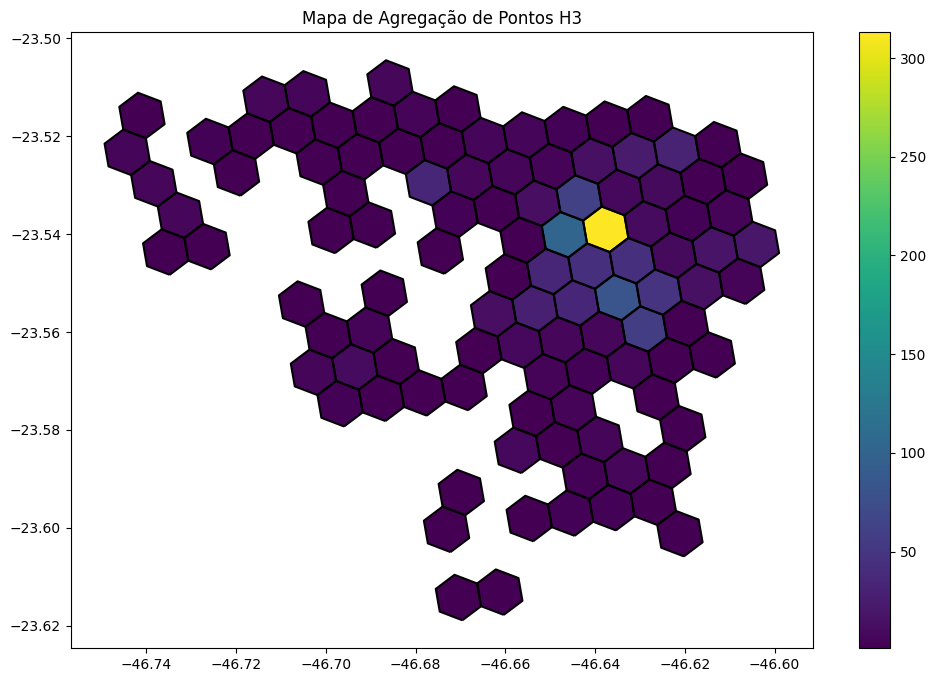

In [33]:
# Plot utilizando geopandas e matplotlib
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
agregado_gdf.boundary.plot(ax=ax, color='black')
agregado_gdf.plot(column='contagem', ax=ax, legend=True, cmap='viridis')
plt.title('Mapa de Agregação de Pontos H3')
plt.show()


In [34]:
# Plot com Folium
# Encontrar o centro do mapa
centroid = agregado_gdf.geometry.centroid
map_center = [centroid.y.mean(), centroid.x.mean()]

<ipython-input-34-81be6591e3c6>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroid = agregado_gdf.geometry.centroid


In [35]:
# Criar o mapa base
m = folium.Map(location=map_center, zoom_start=10, tiles='cartodbpositron')

# Adicionar polígonos ao mapa com um esquema de cores baseando-se no contador
folium.Choropleth(
    geo_data=agregado_gdf,
    name='choropleth',
    data=agregado,
    columns=['h3_index', 'contagem'],
    key_on='feature.properties.h3_index',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Contagem de Pontos por Hexágono',
).add_to(m)

# Exibir controle
folium.LayerControl().add_to(m)

# Salvar o mapa como HTML
m.save("mapa_interativo_classificado.html")
m

In [36]:
import os

# Continuação do código (supondo que já criou 'agregado_gdf' como GeoDataFrame)

# Defina o caminho para salvar o arquivo shapefile no diretório do ambiente do Google Colab
local_output_directory = "/content"
output_shapefile_name = "h3_drogas_agregado.shp"
local_output_shapefile_path = os.path.join(local_output_directory, output_shapefile_name)

# Salvar o GeoDataFrame como shapefile
agregado_gdf.to_file(local_output_shapefile_path, driver='ESRI Shapefile')

print(f"Shapefile salvo com sucesso em {local_output_shapefile_path}!")

# Se você quiser baixar o arquivo shapefile para o computador local
from google.colab import files
# Compactar o shapefile para download mais fácil
!zip -r h3_drogas_agregado.zip /content/h3_drogas_agregado.*

# Faça o download do arquivo zip
files.download("h3_drogas_agregado.zip")

Shapefile salvo com sucesso em /content/h3_drogas_agregado.shp!
  adding: content/h3_drogas_agregado.cpg (stored 0%)
  adding: content/h3_drogas_agregado.dbf (deflated 95%)
  adding: content/h3_drogas_agregado.prj (deflated 17%)
  adding: content/h3_drogas_agregado.shp (deflated 63%)
  adding: content/h3_drogas_agregado.shx (deflated 64%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
!pip3 install contextily
!pip install matplotlib-scalebar

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 44.9 MB/s eta 0:00:00


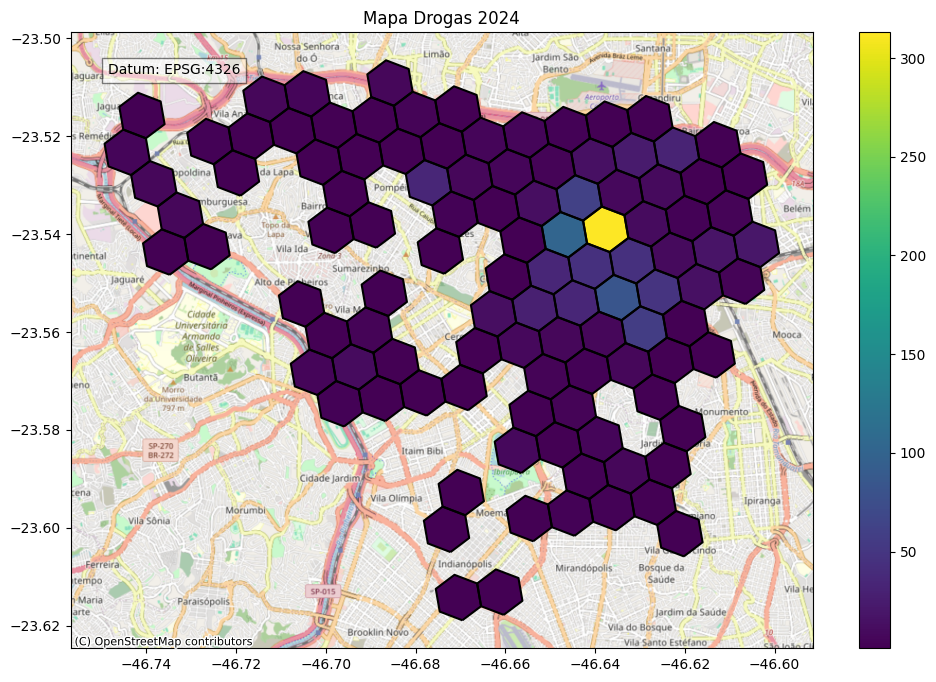

In [40]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

# Supondo que 'agregado_gdf' já foi configurado com dados e geometria
# Vamos plotar junto com um fundo do mapa OpenStreetMap

# Configuração do gráfico
fig, ax = plt.subplots(figsize=(12, 8))

# Plotar as fronteiras do GeoDataFrame
agregado_gdf.boundary.plot(ax=ax, color='black')

# Plotar o mapa de agregação com coloração
agregado_gdf.plot(column='contagem', ax=ax, legend=True, cmap='viridis')

# Adicionar o fundo OpenStreetMap
ctx.add_basemap(ax, crs=agregado_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Adicionar uma seta indicando o norte
x, y, arrow_length = 0.1, 0.1, 0.1
ax.annotate('Norte', xy=(x, y), xytext=(x, y - arrow_length),
            arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='center', verticalalignment='bottom', transform=ax.transAxes)



# Adicionar informações do datum usado (EPSG)
datum_info = f'Datum: {agregado_gdf.crs}'
ax.text(0.05, 0.95, datum_info, ha='left', va='top', transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

# Título e visualização do gráfico
plt.title('Mapa Drogas 2024')
plt.show()